In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Data Exploration

In [2]:
data = pd.read_csv('Sentiment.csv')

In [3]:
data.describe()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
count,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04
mean,6936.000000,0.855689,0.927304,0.756936,0.782801,45.803331,6.296058e+17
std,4004.357127,0.241388,0.141696,0.217682,0.258215,153.981724,9.611863e+13
min,1.000000,0.222200,0.333300,0.186000,0.222200,0.000000,6.294531e+17
25%,3468.500000,0.674200,1.000000,0.651700,0.641300,0.000000,6.294861e+17
50%,6936.000000,1.000000,1.000000,0.681300,1.000000,2.000000,6.296726e+17
75%,10403.500000,1.000000,1.000000,1.000000,1.000000,44.000000,6.296882e+17
max,13871.000000,1.000000,1.000000,1.000000,1.000000,4965.000000,6.297017e+17


In [4]:
data = data[['text', 'sentiment']]

In [5]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


<AxesSubplot:xlabel='sentiment_names'>

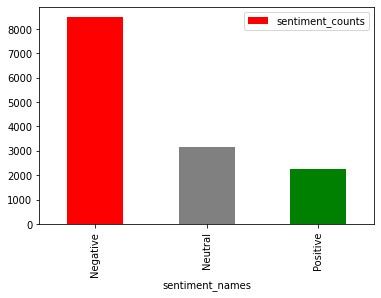

In [6]:
sentiment_counts = data['sentiment'].value_counts()
df_counts = pd.DataFrame({'sentiment_names': sentiment_counts.index, 'sentiment_counts': sentiment_counts})
df_counts.head()
df_counts.plot.bar(x='sentiment_names', y='sentiment_counts', color=['red','gray','green'])

# Data Preprocessing

* Cleaning alphanumeric symbols with regular expresions and removing RTs from each tweet
* Removing stopwords
* Applying stemming
* Converting labels from categorical to numeric

In [7]:
stemmer = SnowballStemmer(language='english') 

def sentiment_to_numeric(sentiment):
    if sentiment == 'Positive':
        return 0
    elif sentiment == 'Neutral':
        return 1
    elif sentiment == 'Negative':
        return 2

def clean_alphanumeric_tokenize_stopwords_stemming(text):
    cleaned_text = re.sub(r'[^\w]', ' ', text).strip()
    cleaned_text = cleaned_text.replace('RT', '').lower()
    tokens = [stemmer.stem(token) for token in word_tokenize(cleaned_text) if not token in stopwords.words('english')]
    tweet = ''
    for token in tokens:
        tweet += token + ' '
    
    return tweet

In [8]:
data['sentiment'] = data['sentiment'].apply(sentiment_to_numeric)
data['text'] = data['text'].apply(clean_alphanumeric_tokenize_stopwords_stemming)

In [9]:
data.head()

,text,sentiment
0,nancyleegrahn everyon feel climat chang questi...,1
1,scottwalk catch full gopdeb last night scott b...,0
2,tjmshow mention tamir rice gopdeb held clevela...,1
3,robgeorg car fiorina trend hour debat men comp...,0
4,danscavino gopdeb w realdonaldtrump deliv high...,0


# Creating Sparse Matrixes and Models

* Applying bag of words
* Applying TF + IDF transformation
* Creating different models: MultinomialNB, Random Forest, SGD, KNN
* Checking models' accuracy using cross validation

In [14]:
c_vect = CountVectorizer()
tfidf = TfidfTransformer()

X = c_vect.fit_transform(data['text'])
X = tfidf.fit_transform(X)

y = data['sentiment']

In [15]:
#MultinomialNB

text_clf = MultinomialNB()
scores = cross_val_score(text_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.63531532 0.63734679 0.63049748 0.64960346 0.61679885]
Mean Score 0.6339123781315561


In [16]:
#KNN Classifier

text_clf = KNeighborsClassifier(n_jobs=-1)
scores = cross_val_score(text_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.54774775 0.53640952 0.53280461 0.6222062  0.63482336]
Mean Score 0.5747982878336159


In [17]:
#SGD Classifier

text_clf = SGDClassifier(n_jobs=-1, random_state=42)
scores = cross_val_score(text_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.66630631 0.67880317 0.62040375 0.6705119  0.68276857]
Mean Score 0.6637587378293939


In [18]:
#Random Forest Classifier

text_clf = RandomForestClassifier(n_jobs=-1)
scores = cross_val_score(text_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.65333333 0.65789474 0.59048306 0.64419611 0.6741168 ]
Mean Score 0.6440048065368902


# Checking Models' Accuracy on Training and Testing Datasets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11096, 15269) (2775, 15269) (11096,) (2775,)


In [20]:
#Train Multinomial NB Classifier

bayes = MultinomialNB()
bayes.fit(X_train, y_train)
bayes_prediction = bayes.predict(X_test)
np.mean(bayes_prediction == y_test)

0.6472072072072073

In [21]:
#Train Random Forest Classifier

forest = RandomForestClassifier(n_jobs=-1, random_state=42)
forest.fit(X_train, y_train)
forest_prediction = forest.predict(X_test)
np.mean(forest_prediction == y_test)

0.6807207207207208

In [22]:
#Train SGD Classifier

sgd = SGDClassifier(n_jobs=-1, random_state=42)
sgd.fit(X_train, y_train)
sgd_prediction = sgd.predict(X_test)
np.mean(sgd_prediction == y_test)

0.6972972972972973

# Confusion Matrix Visualization
* Using seaborn heatmap to visualize final model's performances

In [23]:
sgd_cf = confusion_matrix(sgd_prediction, y_test)
forest_cf = confusion_matrix(forest_prediction, y_test)
bayes_cf = confusion_matrix(bayes_prediction, y_test)

categories = ['Positive', 'Neutral', 'Negative']

<AxesSubplot:>

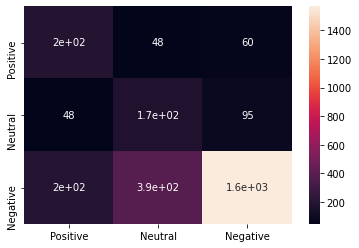

In [24]:
sns.heatmap(sgd_cf, annot=True, xticklabels=categories, yticklabels=categories)

<AxesSubplot:>

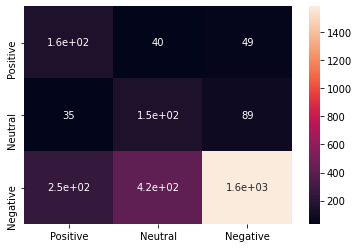

In [25]:
sns.heatmap(forest_cf, annot=True, xticklabels=categories, yticklabels=categories)

<AxesSubplot:>

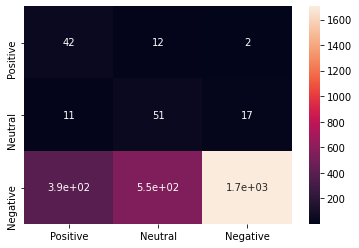

In [26]:
sns.heatmap(bayes_cf, annot=True, xticklabels=categories, yticklabels=categories)

# Conclusion

**SGD Classifier** is the best model with an accuracy of **69.72%**.
I have also tried **MultinomialNB** and **Random Forest Classifier** but their accuracy is lower: **64.72%** and **68.07%**.

The results show a very poor performance for identifying sentiment in tweets. For improving these results, it would be a good idea to explore different models and try to fine-tune its hyperparameters. It is also a good idea to change the data preprocessing and trying different things.